<a href="https://colab.research.google.com/github/serdarbozoglan/My_NLP/blob/master/my_BERT_Document_Classifiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

device_name = 'device/:GPU:0'

if device_name =='device/GPU:0':
    print(f'Found GPU at {device_name}')
else:
    raise SystemError ('GPU device not found')

SystemError: ignored

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')

    print(f"There are {torch.cuda.device_count()} GPU(s) available.")

    print(f"We will use the GPU {torch.cuda.get_device_name(0)}")

else:
    print('No GPU available, using the CPU instead')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU Tesla K80


In [3]:
### Importing Huggingface Transformer library
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 3.0MB 16.2MB/s 
     |████████████████████████████████| 1.1MB 37.9MB/s 
     |████████████████████████████████| 890kB 28.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1cb2783c914c2f1b0b4edce9991b4e139f7927668abdb69d381d191a94135be2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import urllib
import os

os.makedirs('./data/',   exist_ok=True)

In [5]:
# from local computer  Machintosh/User/Serdar/DATASET/wikipedia_personal_attacks altindaki attack_annotated_attacks ve attack_annotations datasetleri yukleyecegiz

In [7]:
import pandas as pd
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep='\t')

print('[INFO] done')

[INFO] done


In [7]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002.0,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002.0,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002.0,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002.0,True,article,random,dev
93890,This page will need disambiguation.,2002.0,True,article,random,train


In [8]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,1895
test,1948
train,5555


In [10]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [11]:
annotations.shape

(219611, 7)

In [12]:
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

comments['attack'] = labels

In [13]:
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002.0,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002.0,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002.0,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002.0,True,article,random,dev,False
93890,This page will need disambiguation.,2002.0,True,article,random,train,False


In [14]:
# Remove newline and tab tokens

comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [15]:
train_commnents = comments.query("split=='train'")
test_commnents = comments.query("split=='test'")

In [16]:
import textwrap
import random

# Wrap text to 80 chars on the screen
# Yani 80 karakterden daha fazlasini alt satira atiyor
wrapper = textwrap.TextWrapper(width=80)

# Filter to just attack comments
attack_examples = train_commnents.query('attack')['comment']

# Randomly choose some examples
for i in range(10):
    j = random.choice(attack_examples.index)

    print('')
    print(wrapper.fill(attack_examples[j]))
    print('')


, I spent 15 minutes working on a blurb on the Chaos movie page, used links to
back up the information and than you removed every fucking word that I wrote.
Burn in hell.


  == also ==  I apologize for mixing up identities. I banged your mom not the
other guys but I won't apologize for that, because she was nice. It was only
about 2 minutes because I'm fast. But she loved all forty seconds of it.


 :What are you retarded? I already am blocked. What a fucking moron.


  You should bar the self proclamed asshole forever!


  HA HA HA OWNED LRH RIDES ON YOU LOSE!


  Blah, blah blah, always telling me off,telling my that I've said something
pointless, the flaunting their precedence. Admins. I hate them.


  ==Try Android79, and DreamGuy==  Both very unpopular with other Wikians, and
both seem to be a%%holes, uneducated, arrogant, and just dumb as a post.
beckjord


`  :Here are the examples that I have compiled since being introduced to this
issue. We have  who complains about your har

In [16]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print(f"{num_attacks} of {total_comments} are attacks {num_attacks/total_comments}")

412 of 5410 are attacks 0.07615526802218114


In [17]:
# Very imbalanced
prcnt_non_attack = 1-(num_attacks/total_comments)
print('Non attack ratio is ', prcnt_non_attack)

Non attack ratio is  0.9238447319778189


### BERT input Lenght Limitation
BERT has a maximum len of 512 tokens.

In [18]:
from transformers import BertTokenizer

print('Loading BERT Tokenizer ...')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer ...


In [19]:
# The first comment in the training set is longer than 512 tokens. 

In [20]:
text = train_commnents.iloc[0].comment

tokens = tokenizer.tokenize(text)

print(f'Comment 0 (not an attack) contains {len(tokens)} WordPiece tokens')
print('\nOriginal coment text:\n')
print(wrapper.fill(text))

Comment 0 (not an attack) contains 591 WordPiece tokens

Original coment text:

`- This is not ``creative``.  Those are the dictionary definitions of the terms
``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you
don't understand that, fine, legitimate criticism, I'll write up ``three man
cell`` and ``bounty hunter`` and then it will be easy to understand why
``ensured`` and ``insured`` are different - and why both differ from
``assured``.  The sentence you quote is absolutely neutral.  You just aren't
familiar with the underlying theory of strike-back (e.g. submarines as employed
in nuclear warfare) guiding the insurance, nor likely the three man cell
structure that kept the IRA from being broken by the British.  If that's my
fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or
``creative`` about it.  I'm tired of arguing with you.  Re: the other article,
``multi-party`` turns up plenty, and there is more use of ``mutually`` than
``mu

In [21]:
# Print out the list of tokens

print('==== First 512 Tokens: ====\n')
print(wrapper.fill(str(' '.join(tokens[:512]))))

print('')
print(f'\n=== Remaining {len(tokens)-512} Tokens: ===\n')
print(wrapper.fill(str(' '.join(tokens[512:]))))

==== First 512 Tokens: ====

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and the

In [22]:
# First trucncate the text to remove the last 79 tokens (which begins with 
# the word "are made in")

last_char = text.find("are made in")

text = text[0:last_char]

# Estimate the number of words in the comment by splitting it on whitespace
# Remove all double spaces

text = text.replace('  ', ' ')
num_words = len(text.split(' '))

print(f'Comment contains {num_words} words')

# Estimate the number of sentences by counting up the periods
num_sents = text.count('. ')

print(f'Comment contains {num_sents} sentences')

Comment contains 330 words
Comment contains 20 sentences


### How to Deal With Long Texts

#### 1. Truncation
. Simplest approach drop some of the tokens
+ From begining of the text
+ At the end of the text
+ In the middle of the text (head + tail)

We need to leave space for **[CLS]** and **[SEP]** tokens as well, so we can use max 510 tokens for each input.

#### 2. Chunkcing


Break the text into multiple chunks. Process the chuncks seperately and combine the results.

Text summarizations might be leveraged before feeding into BERT model. There are 2 types of summarazations. One is **extractive** (text'in orijinal onemli kisimlarini dondurur summary olarak, we don't modify the text), **abstractive** (summary icin yeni bir text generate edilir)

### Tokenize All Comments

`tokenizer.encode` func combines multiple steps for us
+ Split the sentence into tokens
+ Add special token `[CLS]` nd `[SEP]` tokens
+ Map the tokens to theit IDs

In [23]:
import numpy as np
import tqdm

# Tokenize all of the senetences and map the tokens to their word IDs
input_ids =[]

# Record the lenght of each sequence (after truncating to 512)
lengths = []

print('[INFO] Tokenizing comments ...')

# for every sentence ..
for sen in tqdm.tqdm(train_commnents['comment']):

    # Report progress
    if ((len(input_ids) % 500) ==0):
        print(f'Read {len(input_ids)} comments')

    # encode will:
    # (1) Tokenize the sentence
    # (2) Prepend the [CLS] token to the start
    # (3) Append the [SEP] token to the end
    # (4) Map tokens to their IDs

    encoded_sent = tokenizer.encode(
                                    sen, # sentence to encode
                                    add_special_tokens=True # Add '[CLS]' and '[SEP]' tokens
                                    # max_lenght=512 # Truncate all sentences
                                    # return_tensors = 'pt' # Return pytorch tensors
    )

    # Add the ecnoded sentence to the list
    input_ids.append(encoded_sent)

    # Record the truncated length
    lengths.append(len(encoded_sent))

  0%|          | 0/3153 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
  2%|▏         | 74/3153 [00:00<00:04, 707.57it/s]

[INFO] Tokenizing comments ...
Read 0 comments


  8%|▊         | 263/3153 [00:00<00:03, 807.46it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors
 11%|█         | 345/3153 [00:00<00:03, 809.57it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (877 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in ind

Read 500 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors
 25%|██▍       | 779/3153 [00:01<00:03, 707.67it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors
 31%|███▏      | 989/3153 [00:01<00:02, 849.67it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1061 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1698 > 512). Running this sequence through the model will result in 

Read 1000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
 40%|████      | 1273/3153 [00:01<00:02, 855.61it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1072 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1092 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors
 43%|████▎     | 1361/3153 [00:01<00

Read 1500 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
 55%|█████▌    | 1738/3153 [00:02<00:01, 821.06it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longe

Read 2000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2243 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1100 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors
 69%|██████▊   | 2164/3153 [00:02<00:01, 653.98it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is lo

Read 2500 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1175 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1175 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1177 > 512). Running this sequence through the model will result in indexing errors
 85%|████████▍ | 2677/3153 [00:03<00:00, 659.04it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is lo

Read 3000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1273 > 512). Running this sequence through the model will result in indexing errors
 98%|█████████▊| 3090/3153 [00:04<00:00, 535.96it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1069 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (917 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (932 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1011 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is lo

In [24]:
# Also retrieve the label as a list

labels = train_commnents['attack'].to_numpy().astype('int') 

print(f'{np.sum(labels)} positive (contains attack)')
print(f'{len(train_commnents)-np.sum(labels)} negative (not an attack)')

226 positive (contains attack)
2927 negative (not an attack)


In [25]:
print(f'Min length: {min(lengths)} tokens')
print(f'Max lenght: {max(lengths)} tokens')
print(f'Median length: {np.median(lengths)} tokens')

Min length: 2 tokens
Max lenght: 2305 tokens
Median length: 58.0 tokens


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


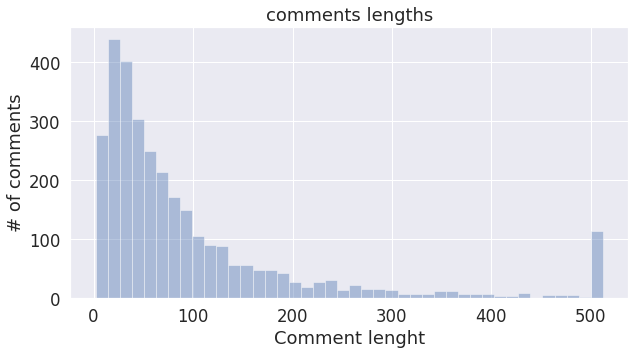

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10,5)

# if text is longer than 512 we will cut off that part for visualization purposes
lengths = [min(l, 512) for l in lengths]

sns.distplot(lengths, kde=False, rug=False)

plt.title('comments lengths')
plt.xlabel('Comment lenght')
plt.ylabel('# of comments');

In [27]:
num_truncated = lengths.count(512)

num_sentences = len(lengths)
prcnt = float(num_truncated/num_sentences)

print(f'{num_truncated} of {len(train_commnents)} in the training set are longer than 512 tokens')

111 of 3153 in the training set are longer than 512 tokens


In [28]:
# how many of those (long comments) include personal attack
num_pos = 0
num_neg = 0

for i, l in enumerate(lengths):

    # if the sentence is trumcated
    if l == 512:

        if labels[i]==1:
            num_pos +=1
        else:
            num_neg +=1

print(f'{num_pos} of truncated examples contain personal attack')

4 of truncated examples contain personal attack


### Pad & Truncate the Comments

Esasinda 512 tokens yeterli gorunuyor ancak speed acisindan 128 token'a indirecegiz. 

Yukaridaki dagilimdan da gorulacegi uzere esasinda 128 tokens length gayet yeterli gorunuyor


In [29]:
from keras.preprocessing.sequence import pad_sequences

# Close to elbow of the above distribution
MAX_LENGTH = 128

print(f'\n[INFO] Padding/Truncating all sentences to {MAX_LENGTH} values ...')
print(f'\nPadding token : {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}')

# Pad out input tokens with value 0
input_ids = pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype='long',
                          value=0, truncating='post', padding='post')

print('\nDone.')


[INFO] Padding/Truncating all sentences to 128 values ...

Padding token : [PAD], ID: 0

Done.


Using TensorFlow backend.


In [30]:
input_ids[33]

array([  101,  2045,  2003,  2053,  2107,  2518,  2004,  3017,  2128,
        3669, 11411, 13013,  6935,  2213,  1012,  2272,  2125,  2009,
        1012,  3531,  2644,  2437,  2039,  2616,  1998,  3015,  4790,
        2006,  5739,  2029,  2123,  1005,  1056,  4839,  1012,  8135,
        2024,  2025,  2130,  2019,  5636,  2177,   999,  2065,  2017,
        2215,  2000,  4339,  2019,  3720,  2006,  4013,  1011,  3017,
       13827,  1010,  2030,  4013,  1011,  3017,  8006,  1010,  2030,
        4013,  1011,  3017, 14405,  2100, 12053,  1010,  2059,  2272,
        2039,  2007,  1037,  3563,  2801,  1010,  1037,  2516,  2241,
        2006,  2755,  1010,  1998,  2707,  3015,  4180,  2008,  5218,
        2000,  1998, 16803,  2006,  6566,  1012,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

#### Attention Mask

The attention mask simply makes it explict whihc tokens are actual words versus which are padding.

The BERT vocab does not use the ID 0 (zero), so if a token ID is 0, then it is padding otherwise it is a real token

In [31]:
# Create attention masks

attention_masks = []

for sent in input_ids:

    att_mask = [int(token_id>0) for token_id in sent]

    attention_masks.append(att_mask)

In [32]:
print(attention_masks[33])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [33]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_y, val_y = train_test_split(input_ids, labels, random_state=4299, test_size=0.1)

# Do the same for masks
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, random_state=4299, test_size=0.1)

In [34]:
# Convert all inputs and labels into torch tensors

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

train_y = torch.tensor(train_y)
val_y = torch.tensor(val_y)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [35]:
# Data loader unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# for BERT fine tuning author recommends 16 or 32 batch size

batch_size = 32

# Create a train dataloader
train_data = TensorDataset(train_inputs, train_masks, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create a validation dataloader
val_data = TensorDataset(val_inputs, val_masks, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### BERT Fine-Tuning

#### Train Our Classification Model

#### BertForSequenceClassification

In [36]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


# Load the BertForSequenceClassification, the pre-trained BERT model with
# a single linear classification layer on top

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # use the 12-layer BERT model, with an uncased vocab
    num_labels = 2, # for binary classification, DIKKAT: eger num_labels=1 yazarsan model bunu regression olarak algilar
    output_attentions = False, # Whether the model returns attentions weight
    output_hidden_states = False # Whether the model returns all hidden-states
)

# Tell PyTorch to run this model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizer

Those are the hyperparameters recomended by authors of BERT

+ Batch size = 16 or 32
+ Learning Rate (Adam) 5e-5, 3e-5, 2e-5 
+ Number of epochs 2, 3, 4

The epsilon parameter eps=1e-8 is a very small number to prevent any division by zero in the implementation

In [37]:
# Note that AdamW is a class from HuggingFace library (as opposed to PyTorch)
# W might mean 'Weight decay fix'

optimizer = AdamW(model.parameters(), 
                  lr=2e-5, # default is 5e-5
                  eps=1e-8)

In [38]:
from transformers import get_linear_schedule_with_warmup

epochs =4 # recommend 2, 3 or 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # default value
                                            num_training_steps = total_steps)

### Training Loop

In each pass, we will train the model on our full training set, and then measure its accuracy on 10% hodout validation set

In [39]:
# Helper func fo accuracy

import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [40]:
# Helper func for formatting elapsed time

import time
import datetime

def format_time(elapsed):


    """Takes a time in seconds and returns a string hh:mm:ss"""
    elapsed_rounded = int(round(elapsed))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
import random

seed_val = 4299

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)


# Store the average loss after each epoch so we can plot them
loss_values = []

for epoch_i in range(0, epochs):

    print("")
    print(f"===== Epoch {epoch_i+1} / {epochs} ===== ")
    print('Training ...')


    # Measure elasped time for each epoch
    t0 = time.time()

    # reset the total loss for this epoch
    total_loss = 0

    # We're putting the model in training mode, it does not perform any training
    # in training and test mode'da dropout and batchnorm layers farkli davranir
    model.train()

    for (step, batch) in enumerate(train_dataloader):

        # Progress update every 100 epochs
        if step % 100 == 0 and not step == 0:
            # Calculate teh elapsed time
            elapsed = format_time(time.time() - t0)

            # Report progress
            print(f'Batch {step} of {len(train_dataloader)}, Elapsed: {elapsed}')


        # Unpack this training batch from our dataloader
        #  [0]: input_ids
        #  [1]: attention_masks
        #  [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated graients before perfroming a 
        # backward pass. Pytorch does not do it atomatically because
        # accumating the gradients is convinient while training RNNs
        model.zero_grad()

        # Perform a forward pass
        # This will return loss rather than the model output becuase
        # we have provided labels
        # token_type_ids is teh same as the "segment_ids" which
        # differantiates sentence 1 and sentence 2 tasks
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        
        # The call to 'model' always return a tupple, so we need to pull 
        # the value out of the tupple
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing 
        # a single value; the .item() func returns a Python value from the tensor
        total_loss += loss.item()

        # perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update the parameters and take a step using the computed gradient
        # the optimizer dictates the update rule how the parameters
        # are modified based on their gradients, leraning rates etc
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate teh average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value of plotting the learning curve
    loss_values.append(avg_train_loss)

    print("")
    print(f' Average training loss: {avg_train_loss}')
    print(f' Training epoch took: {format_time(time.time()- t0)}')


    #### ==========VALIDATION============
    

    print("")
    print('Running Validation... ')

    t0 = time.time()

    # Put the model in evaluation mode in which droupout layers 
    # behave differently than train mode
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

             # Forward pass, calculate logit predictions
             # This will return the logits rather than the loss because we have
             # not provided labels
             # token_type_ids is teh same as the "segment_ids" which
             # differantiates sentence 1 and sentence 2 tasks
             outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask)
             
        # Get the logits output by the model. The logits are the output
        # values prior to applying an activation function like softmax 
        logits = outputs[0]

        # Move logits and labes to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the finala accuracy for this validation
    print(f" Accuracy: {eval_accuracy/nb_eval_steps}")  
    print(f"Validation took {format_time(time.time()-t0)}")

print("")
print("Training completed!")


===== Epoch 1 / 4 ===== 
Training ...

 Average training loss: 0.2379210272364402
 Training epoch took: 0:01:05

Running Validation... 
 Accuracy: 0.9491071428571429
Validation took 0:00:02

===== Epoch 2 / 4 ===== 
Training ...

 Average training loss: 0.10653823469713163
 Training epoch took: 0:01:06

Running Validation... 
 Accuracy: 0.946875
Validation took 0:00:02

===== Epoch 3 / 4 ===== 
Training ...

 Average training loss: 0.05173734960596213
 Training epoch took: 0:01:06

Running Validation... 
 Accuracy: 0.953125
Validation took 0:00:02

===== Epoch 4 / 4 ===== 
Training ...

 Average training loss: 0.02856696059069272
 Training epoch took: 0:01:06

Running Validation... 
 Accuracy: 0.9522321428571429
Validation took 0:00:02

Training completed!


Text(0, 0.5, 'Loss')

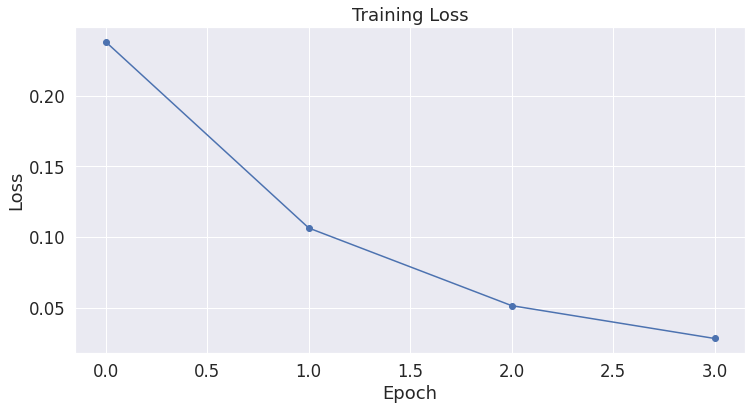

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] =(12,6)

# Plot the learning curve
plt.plot(loss_values, 'b-o')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


### Performance of Test Set

We will do the same preparation for the test set what we have did for training set

In [44]:
# Tokenize all of the sentences and map the tokens to their word IDs
test_input_ids = []

# For every sentence ...
for sen in test_commnents['comment']:

    # Report progress
    if ((len(input_ids) % 1000) ==0):
        print(f'Read {len(input_ids)} comments')

    # encode will:
    # (1) Tokenize the sentence
    # (2) Prepend the [CLS] token to the start
    # (3) Append the [SEP] token to the end
    # (4) Map tokens to their IDs

    encoded_sent = tokenizer.encode(
                                    sen, # sentence to encode
                                    add_special_tokens=True, # Add '[CLS]' and '[SEP]' tokens
                                    max_length=MAX_LENGTH # Truncate all sentences
                                )

    # Add the ecnoded sentence to the list
    test_input_ids.append(encoded_sent)

    # Record the truncated length
    lengths.append(len(encoded_sent))

print("DONE.")
print("")
print(f'{len(test_input_ids)} test comments.')

test_labels = test_commnents['attack'].to_numpy().astype(int)

print(f"{np.sum(test_labels)} positive (contains attack)")
print(f"{len(test_labels)-np.sum(test_labels)} negative (not an attack)")

# Padding
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LENGTH,
                               dtype='long', truncating='post', padding='post')

# Create attention masks
test_attention_mask = []

for seq in test_input_ids:

    seq_mask = [int(token_id>0) for token_id in seq]
    test_attention_mask.append(seq_mask)

# Convert all inputs and labels into torch tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_mask)
test_y = torch.tensor(test_labels)

# Batch
batch_size= 32

# Create DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

DONE.

1162 test comments.
93 positive (contains attack)
1069 negative (not an attack)


In [45]:
# Prediction on the test set

print(f"Predicting labels for {len(test_inputs)}")

# Put model on evaluation mode
model.eval()

# Tracking varaibles
predictions, true_labels = [], []

# Measure elasped time
t0 = time.time()

# Predict
for (step, batch) in enumerate(test_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Progress update every 100 epochs
    if step % 100 == 0 and not step == 0:
        # Calculate teh elapsed time
        elapsed = format_time(time.time() - t0)

        # Report progress
        print(f'Batch {step} of {len(test_dataloader)}, Elapsed: {elapsed}')


        # Unpack this training batch from our dataloader
        #  [0]: input_ids
        #  [1]: attention_masks
        #  [2]: labels

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

        # Forward pass, calculate logit predictions
        # This will return the logits rather than the loss because we have
        # not provided labels
        # token_type_ids is teh same as the "segment_ids" which
        # differantiates sentence 1 and sentence 2 tasks
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
             
    # Get the logits output by the model. The logits are the output
    # values prior to applying an activation function like softmax 
    logits = outputs[0]

    # Move logits and labes to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')




Predicting labels for 1162
DONE.


In [47]:
# Combine the results across the batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [48]:
predictions[:10]
# first column shows non personal attack (Class 0) and second column shows (personal attack Class 1)
# high confidence leevel for class 0 and low confidence for class 1

array([[ 2.702563 , -3.6623566],
       [ 2.6356704, -3.4786842],
       [ 2.6891954, -3.6642716],
       [ 2.619429 , -3.657702 ],
       [ 2.5679648, -3.4654768],
       [ 2.7191179, -3.5396974],
       [ 2.712379 , -3.6464007],
       [ 2.7564862, -3.679482 ],
       [ 2.6851203, -3.6449034],
       [ 2.6865926, -3.6938279]], dtype=float32)

In [49]:
true_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
# The metric is chose for this dataset is ROC AUC by the author of dataset
from sklearn.metrics import roc_auc_score

# use the model output for Class 1 as our predictions
# Yani yukaridaki prediction'daki second column i, Class 1 olarak tanimliyoruz
p1 = predictions[:, 1]

In [51]:
p1

array([-3.6623566, -3.4786842, -3.6642716, ..., -3.6934326, -3.3778746,
       -3.677268 ], dtype=float32)

In [52]:
true_labels

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
# Calculate the ROC AUC
auc = roc_auc_score(true_labels, p1)
print('Test AUC : ', auc)

Test AUC :  0.962571793556434


In [ ]:
# Original notebook (Tf-idf + Logistic Regression) is 95.7

### Save Trained Model

In [57]:
output_dir = './model_save/'
os.makedirs(output_dir, exist_ok=True)

In [59]:
print(f'Saving model to {output_dir}')

Saving model to ./model_save/


In [60]:
# Save a trained model, configuration and tokenizer using 'save_pretrained()`
# They can then be reloaded using `from_pretrained`

model_to_save = model.module if hasattr(model, 'module') else model # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin))

('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

### Backing Up to Google Drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
gdrive_path = './drive/My Drive/BERT Document Classification Tutorial/model_save/'
os.makedirs(gdrive_path, exist_ok=True)

In [22]:
!cp -r ./model_save/ "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

cp: cannot stat './model_save/': No such file or directory


### Semantic Similarity

IMPORTANT: Before we can use out fine-tuned model for extracting embeddings, we first need to reload the model
from disk with the `output_hidden_states` flag to set True



In [40]:
model.output_hidden_states=True

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!cp -r "drive/My Drive//BERT Document Classification Tutorial/model_save/model_save" ./model_save/

In [33]:
from transformers import BertForSequenceClassification, BertTokenizer

output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the 'hidden states'
model = BertForSequenceClassification.from_pretrained(output_dir,
                                                      output_hidden_states=True) # Whether the model returns all hidden-states.

tokenizer = BertTokenizer.from_pretrained(output_dir)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### text_to_embedding function

Here we'll define a function which can take an arbitrary piece of text and use our fine-tuned BERT model to compute a feature vector (embedding) for the text

We will be using 768-feature vector corresponding to the special `[CLS]` token, taken from the final transformer layer.

Note that for converting large amount of text, we could improve our performance by modifying this func to accept multiple input text at once. GPUS are most efficient when they are given a batch of inputs to work on 

In [37]:
import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    """
        Uses the provided BERT model and tokenizer to generate a vector
        representation of input string, in_text
        
        returns the vector stored as a numpy ndarray
    """

    # =============================
    # STEP 1: tokenization
    # =============================

    MAX_LENGTH = 128

    input_ids = tokenizer.encode(
                                in_text, # sentence to encode
                                add_special_tokens=True, # Add '[CLS]' and '[SEP]' tokens
                                max_length=MAX_LENGTH # Truncate all sentences
                                )
    
    # Pad out input tokens with value 0
    # Truncation was handled by above encode func which also makes sure
    # that [SEP] token is placed after truncation
    # NOTE: pad_sequences expects LIST OF LISTs but we have only one piece 
    # of text so we surround input_ids with an extra set of brackets
    results = pad_sequences([input_ids], maxlen=MAX_LENGTH, dtype='long',
                            truncating='post', padding='post')
    
    # Remove the outer list
    input_ids = results[0]

    # Create attention mask
    attn_mask = [int(i>0) for i in input_ids]

    # Cast to tensors
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the batch (even tough there is only one input
    # in this batch)
    input_ids = input_ids.unsqueeze(0)
    attn_maks = attn_mask.unsqueeze(0)


    #============================
    # Step 2: BERT Model
    #============================

    model.eval()

    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)

    # Forward pass, return hidden states and predicitons
    # This will return logits rather than the loss because we 
    # have not provided labels
    with torch.no_grad():
        logits, encoded_layers = model(input_ids=input_ids,
                                       token_type_ids = None,
                                       attention_mask = attn_mask)
        
    layer_i = 12 #The last BERT layer before the classifier
    batch_i = 0 #Only one input in the batch
    token_i = 0 #The first token, corresponding to [CLS]

    # Grab the embedding
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to CPU
    vec.detach().cpu().numpy()

    return (vec) 

In [38]:
# Get the text from one of the comments
input_text = comments.iloc[10]['comment']

# Use textwrapper to print nicely
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="     ",
                               width=80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. embedding shape ', str(vec.shape))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Getting embedding for sentence:

       :Correct. Full biographical details will put down his birth details, etc.
     It is just a marker to me at the moment to detail the WR aspect. He
     certainly wasn't Belarus; as a geo-political entity it had no real
     existence at the time. I have put a tbc marker on this article for now.


ValueError: ignored

In [39]:
input_ids.shape


NameError: ignored